In [1]:
# Clean install of torch and torchvision
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [1]:
# Install torch with correct CUDA support for Colab
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.4 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class TeacherCNN(nn.Module):
    def __init__(self):
        super(TeacherCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [5]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += xb.size(0)
    return correct / total


In [7]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# Define transform for Clean Dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load Clean MNIST dataset
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 55.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.74MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.64MB/s]


In [8]:
# Define function to add Gaussian noise
def add_gaussian_noise(tensor_images, std=0.3):
    noise = torch.randn_like(tensor_images) * std
    noisy = tensor_images + noise
    return torch.clip(noisy, 0., 1.)

# Apply noise to test images only
noisy_test_images = add_gaussian_noise(test_data.data.unsqueeze(1).float() / 255.)
noisy_test_labels = test_data.targets
noisy_test_dataset = TensorDataset(noisy_test_images, noisy_test_labels)
noisy_test_loader = DataLoader(noisy_test_dataset, batch_size=256, shuffle=False)


In [9]:
teacher = TeacherCNN().to(device)
optimizer = torch.optim.Adam(teacher.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_teacher(teacher, train_loader, optimizer, criterion)

acc_clean_teacher = evaluate(teacher, test_loader)
print(f"✅ Teacher Accuracy on Clean Test Set: {acc_clean_teacher*100:.2f}%")


Epoch 1: Loss=0.3102, Accuracy=0.9092
Epoch 2: Loss=0.0707, Accuracy=0.9784
Epoch 3: Loss=0.0474, Accuracy=0.9857
Epoch 4: Loss=0.0365, Accuracy=0.9885
Epoch 5: Loss=0.0294, Accuracy=0.9909
✅ Teacher Accuracy on Clean Test Set: 98.79%


In [11]:
# Simple Student CNN architecture
class StudentCNN(nn.Module):
    def __init__(self):
        super(StudentCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28x28 -> 14x14
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 -> 7x7
        x = x.view(-1, 16 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [12]:
# Define student model
student_clean = StudentCNN().to(device)
optimizer_student_clean = torch.optim.Adam(student_clean.parameters(), lr=1e-3)

# KD loss function (Soft Targets + Temperature)
def kd_loss_function(student_outputs, teacher_outputs, true_labels, T=4, alpha=0.7):
    kd_loss = nn.KLDivLoss(reduction="batchmean")(
        F.log_softmax(student_outputs / T, dim=1),
        F.softmax(teacher_outputs / T, dim=1)
    ) * (T * T)
    ce_loss = F.cross_entropy(student_outputs, true_labels)
    return alpha * kd_loss + (1 - alpha) * ce_loss

# Training KD on clean dataset
def train_student_kd(student_model, teacher_model, train_loader, optimizer, T=4, alpha=0.7, epochs=5):
    teacher_model.eval()
    for epoch in range(epochs):
        student_model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            with torch.no_grad():
                teacher_output = teacher_model(xb)
            student_output = student_model(xb)
            loss = kd_loss_function(student_output, teacher_output, yb, T, alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"KD Clean Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f}")

# Train student model on clean data
train_student_kd(student_clean, teacher, train_loader, optimizer_student_clean)

# Evaluate student on clean and noisy
acc_student_clean_clean = evaluate(student_clean, test_loader)
acc_student_clean_noisy = evaluate(student_clean, noisy_test_loader)

print(f"✅ Student KD (Clean) Accuracy - Clean: {acc_student_clean_clean*100:.2f}%, Noisy: {acc_student_clean_noisy*100:.2f}%")


KD Clean Epoch 1 - Loss: 3.5337
KD Clean Epoch 2 - Loss: 0.4535
KD Clean Epoch 3 - Loss: 0.2519
KD Clean Epoch 4 - Loss: 0.1842
KD Clean Epoch 5 - Loss: 0.1485
✅ Student KD (Clean) Accuracy - Clean: 98.40%, Noisy: 93.14%


In [13]:
# Create new instance for noisy KD student
student_noisy = StudentCNN().to(device)
optimizer_student_noisy = torch.optim.Adam(student_noisy.parameters(), lr=1e-3)

# Train student model using noisy images but teacher outputs from clean
def train_student_kd_noisy(student_model, teacher_model, noisy_loader, optimizer, T=4, alpha=0.7, epochs=5):
    teacher_model.eval()
    for epoch in range(epochs):
        student_model.train()
        total_loss = 0
        for xb, yb in noisy_loader:
            xb, yb = xb.to(device), yb.to(device)
            with torch.no_grad():
                teacher_output = teacher_model(xb)  # Use same input, noisy, for KD
            student_output = student_model(xb)
            loss = kd_loss_function(student_output, teacher_output, yb, T, alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"KD Noisy Epoch {epoch+1} - Loss: {total_loss/len(noisy_loader):.4f}")

# Run training for noisy KD
train_student_kd_noisy(student_noisy, teacher, noisy_test_loader, optimizer_student_noisy)

# Evaluate on clean and noisy test sets
acc_student_noisy_clean = evaluate(student_noisy, test_loader)
acc_student_noisy_noisy = evaluate(student_noisy, noisy_test_loader)

print(f"✅ Student KD (Noisy) Accuracy - Clean: {acc_student_noisy_clean*100:.2f}%, Noisy: {acc_student_noisy_noisy*100:.2f}%")


KD Noisy Epoch 1 - Loss: 9.1180
KD Noisy Epoch 2 - Loss: 4.8451
KD Noisy Epoch 3 - Loss: 2.7244
KD Noisy Epoch 4 - Loss: 2.1263
KD Noisy Epoch 5 - Loss: 1.7927
✅ Student KD (Noisy) Accuracy - Clean: 89.45%, Noisy: 87.11%


In [15]:
# Already defined earlier (optional re-confirmation)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate teacher model on noisy test set
acc_noisy_teacher = evaluate(teacher, noisy_test_loader)
print(f"📌 Teacher Accuracy on Noisy Dataset: {acc_noisy_teacher*100:.2f}%")


📌 Teacher Accuracy on Noisy Dataset: 96.12%


📈 Final Comparison Table:
                Model  Accuracy on Clean (%)  Accuracy on Noisy (%)
0             Teacher                  98.79                  96.12
1  Student (Clean KD)                  98.40                  93.14
2  Student (Noisy KD)                  89.45                  87.11


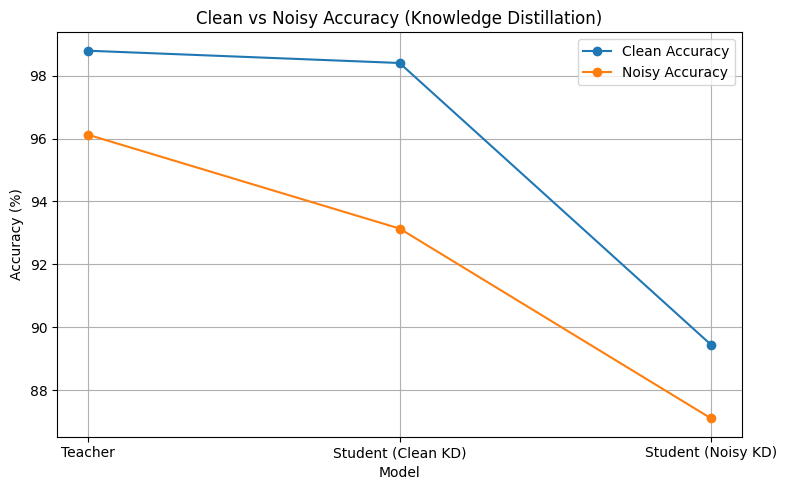

In [16]:
# 📋 Create a comparison table
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame({
    "Model": ["Teacher", "Student (Clean KD)", "Student (Noisy KD)"],
    "Accuracy on Clean (%)": [
        acc_clean_teacher * 100,
        acc_student_clean_clean * 100,
        acc_student_noisy_clean * 100
    ],
    "Accuracy on Noisy (%)": [
        acc_noisy_teacher * 100,
        acc_student_clean_noisy * 100,
        acc_student_noisy_noisy * 100
    ]
})

print("📈 Final Comparison Table:")
print(results_df)

# 📈 Line Graph for Visualization
plt.figure(figsize=(8, 5))
x = range(len(results_df))
plt.plot(x, results_df["Accuracy on Clean (%)"], marker='o', label="Clean Accuracy")
plt.plot(x, results_df["Accuracy on Noisy (%)"], marker='o', label="Noisy Accuracy")
plt.xticks(x, results_df["Model"])
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Clean vs Noisy Accuracy (Knowledge Distillation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
